# Business Problem

### Objective
- Assess whether a customer's license should be issued (AAI), renewed (REV), or canceled (AAC) based on various parameters.
- Learn from the features of previously rejected or approved applications to make informed decisions.

---


In [1]:
# Import necessary libraries
import h2o  # Import the H2O library
from h2o.estimators import H2OGradientBoostingEstimator, H2ORandomForestEstimator  # Import H2O's gradient boosting and random forest estimators
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 


In [ ]:
# Initialize and start the H2O cluster
h2o.init()

In [3]:
# Set the maximum number of columns to be displayed in Pandas data frames to 500
pd.set_option('display.max_columns', 500)

# Set the maximum number of rows to be displayed in Pandas data frames to 500
pd.set_option('display.max_rows', 500)


In [ ]:
# Read a CSV file named "License_Data.csv" located in the "input" directory
pdf = pd.read_csv("input/License_Data.csv")

# Print the shape (number of rows and columns) of the DataFrame
print(pdf.shape)


In [5]:
# Count the occurrences of each unique value in the "LICENSE_STATUS" column
pdf.LICENSE_STATUS.value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: LICENSE_STATUS, dtype: int64

In [6]:
# Filter the DataFrame "pdf" to include only rows where the "LICENSE_STATUS" column has values 'AAI', 'AAC', or 'REV'
pdf = pdf[pdf.LICENSE_STATUS.isin(['AAI', 'AAC', 'REV'])]

In [7]:
# Count missing values in each column
pdf.isna().sum()

ID                                       0
LICENSE_ID                               0
ACCOUNT_NUMBER                           0
SITE_NUMBER                              0
LEGAL_NAME                               0
DOING_BUSINESS_AS_NAME                   1
ADDRESS                                  0
CITY                                     0
STATE                                    0
ZIP_CODE                                31
WARD                                 49699
PRECINCT                             56699
WARD_PRECINCT                        49698
POLICE_DISTRICT                      54010
LICENSE_CODE                             0
LICENSE_DESCRIPTION                      0
LICENSE_NUMBER                           1
APPLICATION_TYPE                         0
APPLICATION_CREATED_DATE             64657
APPLICATION_REQUIREMENTS_COMPLETE      214
PAYMENT_DATE                          1287
CONDITIONAL_APPROVAL                     0
LICENSE_TERM_START_DATE                228
LICENSE_TER

In [8]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85890 entries, 0 to 85894
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 85890 non-null  object 
 1   LICENSE_ID                         85890 non-null  int64  
 2   ACCOUNT_NUMBER                     85890 non-null  int64  
 3   SITE_NUMBER                        85890 non-null  int64  
 4   LEGAL_NAME                         85890 non-null  object 
 5   DOING_BUSINESS_AS_NAME             85889 non-null  object 
 6   ADDRESS                            85890 non-null  object 
 7   CITY                               85890 non-null  object 
 8   STATE                              85890 non-null  object 
 9   ZIP_CODE                           85859 non-null  object 
 10  WARD                               36191 non-null  float64
 11  PRECINCT                           29191 non-null  flo

In [9]:
# Count unique values per column in "pdf"
pdf.nunique()

ID                                   85890
LICENSE_ID                           85890
ACCOUNT_NUMBER                       38895
SITE_NUMBER                            177
LEGAL_NAME                           38742
DOING_BUSINESS_AS_NAME               41684
ADDRESS                              42143
CITY                                  1223
STATE                                   54
ZIP_CODE                              2456
WARD                                    50
PRECINCT                                76
WARD_PRECINCT                         2383
POLICE_DISTRICT                         28
LICENSE_CODE                           106
LICENSE_DESCRIPTION                    106
LICENSE_NUMBER                       49764
APPLICATION_TYPE                         5
APPLICATION_CREATED_DATE              2899
APPLICATION_REQUIREMENTS_COMPLETE     3078
PAYMENT_DATE                          4356
CONDITIONAL_APPROVAL                     2
LICENSE_TERM_START_DATE               2825
LICENSE_TER

In [10]:
pdf.head()

,ID,LICENSE_ID,ACCOUNT_NUMBER,SITE_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,LICENSE_NUMBER,APPLICATION_TYPE,APPLICATION_CREATED_DATE,APPLICATION_REQUIREMENTS_COMPLETE,PAYMENT_DATE,CONDITIONAL_APPROVAL,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_APPROVED_FOR_ISSUANCE,DATE_ISSUED,LICENSE_STATUS_CHANGE_DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE_STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,22.0,28.0,22-28,10.0,1010,Limited Business License,35342.0,RENEW,NaN,2002-06-28T00:00:00,2002-08-21T00:00:00,N,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25.0,41.843613,-87.714618,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,33.0,23.0,33-23,17.0,1315,Mobile Food Dispenser,1358463.0,RENEW,NaN,2005-09-22T00:00:00,2005-11-03T00:00:00,N,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60.0,41.961132,-87.699626,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,NaN,NaN,NaN,NaN,1011,Home Repair,1980233.0,ISSUE,2009-06-29T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,N,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,NaN,NaN,NaN,NaN,1010,Limited Business License,1476582.0,ISSUE,2004-02-10T00:00:00,2004-02-10T00:00:00,2004-02-10T00:00:00,N,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,NaN,NaN,NaN,NaN,1010,Limited Business License,1141408.0,RENEW,NaN,2008-03-24T00:00:00,2008-06-04T00:00:00,N,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI


In [ ]:
# Create a count plot to visualize the distribution of values in the 'LICENSE_STATUS' column
sns.countplot(pdf['LICENSE_STATUS'])

# Display the plot
plt.show()


In [12]:
# Count the occurrences of each unique value in the "CONDITIONAL_APPROVAL" column
pdf.CONDITIONAL_APPROVAL.value_counts()


N    85872
Y       18
Name: CONDITIONAL_APPROVAL, dtype: int64

In [13]:
# Create a new column 'LEGAL_BUSINESS_NAME_MATCH' in the DataFrame "pdf" based on a matching condition
pdf['LEGAL_BUSINESS_NAME_MATCH'] = pdf.apply(lambda x: 1 if (str(x['LEGAL_NAME'].upper()) in str(x['DOING_BUSINESS_AS_NAME']).upper()) 
                                             or (str(x['DOING_BUSINESS_AS_NAME']).upper() in str(x['LEGAL_NAME']).upper()) else 0,
                                             axis=1)


In [14]:
# Count the occurrences of each unique value in the "LICENSE_DESCRIPTION" column
pdf['LICENSE_DESCRIPTION'].value_counts()


Limited Business License                                        50077
Home Repair                                                     10632
Peddler, non-food                                                2812
Home Occupation                                                  2809
Retail Food Establishment                                        2320
Massage Therapist                                                1952
Street Performer                                                 1889
Scavenger, Private                                               1549
Hazardous Materials                                              1126
Residential Real Estate Developer                                1087
Motor Vehicle Repair : Engine Only (Class II)                     931
Automatic Amusement Device Operator                               773
Peddler, food (fruits and vegtables only)                         582
Mobile Food Dispenser                                             525
Manufacturing Establ

In [15]:
# Replace specific values in the 'LICENSE_DESCRIPTION' column with more general descriptions

# Motor Vehicle Repair
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Motor Vehicle Repair : Engine Only (Class II)', 'Motor Vehicle Repair')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Motor Vehicle Repair: Engine/Body(Class III)', 'Motor Vehicle Repair')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Motor Vehicle Repair; Specialty(Class I)', 'Motor Vehicle Repair')

# Day Care Center
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Day Care Center Under 2 Years', 'Day Care Center')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Day Care Center 2 - 6 Years', 'Day Care Center')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Day Care Center Under 2 and 2 - 6 Years', 'Day Care Center')

# Peddler
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Peddler, non-food', 'Peddler')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Peddler, non-food, special', 'Peddler')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Peddler, food (fruits and vegetables only)', 'Peddler')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Peddler,food - (fruits and vegetables only) - special', 'Peddler')

# Tire Facility
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Tire Facility Class I (100 - 1,000 Tires)', 'Tire Facility')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Tire Facility Class II (1,001 - 5,000 Tires)', 'Tire Facility')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Tire Facility Class III (5,001 - More Tires)', 'Tire Facility')

# Repossessor
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Repossessor Class A', 'Repossessor')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Repossessor Class B', 'Repossessor')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Repossessor Class B Employee', 'Repossessor')

# Expediter
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Expediter - Class B', 'Expediter')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Expediter - Class A', 'Expediter')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Expediter - Class B Employee', 'Expediter')

# Itinerant Merchant
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Itinerant Merchant, Class II', 'Itinerant Merchant')
pdf['LICENSE_DESCRIPTION'] = pdf['LICENSE_DESCRIPTION'].replace(
    'Itinerant Merchant, Class I', 'Itinerant Merchant')


In [16]:
# Calculate the number of unique values in the 'LICENSE_DESCRIPTION'
pdf['LICENSE_DESCRIPTION'].nunique()


92

In [17]:
# Remove periods (.) from the 'LEGAL_NAME' and 'DOING_BUSINESS_AS_NAME' columns
pdf['LEGAL_NAME'] = pdf['LEGAL_NAME'].str.replace('.', '', regex=False)
pdf['DOING_BUSINESS_AS_NAME'] = pdf['DOING_BUSINESS_AS_NAME'].str replace('.', '', regex=False)

# Set the initial 'BUSINESS_TYPE' to 'PVT' for private businesses
pdf['BUSINESS_TYPE'] = 'PVT'

# Update 'BUSINESS_TYPE' based on keyword matching
pdf['BUSINESS_TYPE'] = np.where(pdf['LEGAL_NAME'].str.contains('INC') | pdf['LEGAL_NAME'].str.contains('INCORPORATED'), 'INC', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['DOING_BUSINESS_AS_NAME'].str.contains('INC') | pdf['DOING_BUSINESS_AS_NAME'].str.contains('INCORPORATED'), 'INC', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['LEGAL_NAME'].str.contains('LLC'), 'LLC', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['DOING_BUSINESS_AS_NAME'].str.contains('LLC'), 'LLC', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['LEGAL_NAME'].str.contains('CO') | pdf['LEGAL_NAME'].str.contains('CORP') | pdf['LEGAL_NAME'].str.contains('CORPORATION'), 'CORP', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['DOING_BUSINESS_AS_NAME'].str.contains('CO') | pdf['DOING_BUSINESS_AS_NAME'].str.contains('CORP') | pdf['DOING_BUSINESS_AS_NAME'].str.contains('CORPORATION'), 'CORP', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['LEGAL_NAME'].str.contains('LTD') | pdf['LEGAL_NAME'].str.contains('LIMITED'), 'LTD', pdf['BUSINESS_TYPE'])
pdf['BUSINESS_TYPE'] = np.where(pdf['DOING_BUSINESS_AS_NAME'].str.contains('LTD') | pdf['DOING_BUSINESS_AS_NAME'].str.contains('LIMITED'), 'LTD', pdf['BUSINESS_TYPE'])


In [18]:
# Count the occurrences of each unique value in the 'BUSINESS_TYPE' column
pdf['BUSINESS_TYPE'].value_counts()


CORP    27763
PVT     27020
INC     24443
LLC      5048
LTD      1616
Name: BUSINESS_TYPE, dtype: int64

In [ ]:
# Create a count plot to visualize the distribution of values in the 'BUSINESS_TYPE' column
sns.countplot(pdf['BUSINESS_TYPE'])

# Display the plot
plt.show()

In [20]:
# Count the occurrences of each unique value in the 'ZIP_CODE' column
pdf.ZIP_CODE.value_counts()

60804      1142
60647.0     925
60618       889
60639       878
60007       789
           ... 
13204.0       1
20774         1
40202         1
10036.0       1
30188         1
Name: ZIP_CODE, Length: 2456, dtype: int64

In [21]:
# Fill missing values in the 'ZIP_CODE' column with -1
pdf['ZIP_CODE'].fillna(-1, inplace=True)

# Create a new column 'ZIP_CODE_MISSING' to indicate missing ZIP codes
pdf['ZIP_CODE_MISSING'] = pdf.apply(lambda x: 1 if x['ZIP_CODE'] == -1 else 0, axis=1)

<AxesSubplot:ylabel='Frequency'>

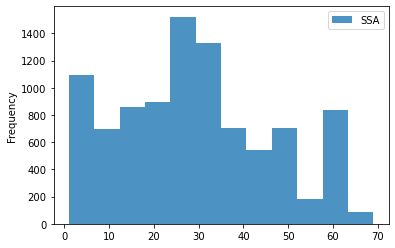

In [22]:
# Create a histogram plot for the 'SSA' column with 12 bins and alpha (transparency) value of 0.8
pdf[['SSA']].plot.hist(bins=12, alpha=0.8)

In [23]:
# Fill missing values in the 'SSA' column with -1
pdf['SSA'].fillna(-1, inplace=True)


In [24]:
# Fill missing values in the 'APPLICATION_REQUIREMENTS_COMPLETE' column with -1
pdf['APPLICATION_REQUIREMENTS_COMPLETE'].fillna(-1, inplace=True)

# Update the 'APPLICATION_REQUIREMENTS_COMPLETE' column to 0 for missing values, and 1 for non-missing values
pdf['APPLICATION_REQUIREMENTS_COMPLETE'] = pdf.apply(lambda x: 0 if x['APPLICATION_REQUIREMENTS_COMPLETE'] == -1 else 1, axis=1)


# Train Test Split

In [25]:
# Split the DataFrame "pdf" into training and test sets
train, test = train_test_split(pdf, test_size=0.2, random_state=123)


In [26]:
# Convert Pandas DataFrames "train" and "test" to H2OFrames
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
# Create an H2O Random Forest estimator with specified parameters
h2o_rf = H2ORandomForestEstimator(ntrees=100, seed=123, max_depth=10)

# Train the estimator using the selected features ('x') and the target variable ('y') on the training data
h2o_rf.train(x=['APPLICATION_TYPE', 'CONDITIONAL_APPROVAL', 'LICENSE_CODE', 'SSA', 'LEGAL_BUSINESS_NAME_MATCH', 
                'ZIP_CODE_MISSING', 'SSA', 'APPLICATION_REQUIREMENTS_COMPLETE', 'LICENSE_DESCRIPTION', 'BUSINESS_TYPE'], 
             y='LICENSE_STATUS', training_frame=train)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1635349463504_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,300.0,1289405.0,10.0,10.0,10.0,52.0,449.0,272.18




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.1595309785671954
RMSE: 0.3994132929275081
LogLoss: 0.4956308711207337
Mean Per-Class Error: 0.5010083289322868
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,AAC,AAI,REV,Error,Rate
0,12233.0,11861.0,18.0,0.492659,"11,879 / 24,112"
1,2847.0,41529.0,1.0,0.064177,"2,848 / 44,377"
2,175.0,36.0,12.0,0.946188,211 / 223
3,15255.0,53426.0,31.0,0.217400,"14,938 / 68,712"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.78260
1,2,0.99904
2,3,1.00000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-27 21:14:37,0.065 sec,0.0,NaN,NaN,NaN,NaN,NaN
1,,2021-10-27 21:14:37,0.554 sec,1.0,0.403304,0.638051,0.220504,NaN,NaN
2,,2021-10-27 21:14:37,0.800 sec,2.0,0.403750,0.618222,0.220586,NaN,NaN
3,,2021-10-27 21:14:38,1.036 sec,3.0,0.403160,0.612821,0.219389,NaN,NaN
4,,2021-10-27 21:14:38,1.159 sec,4.0,0.402172,0.587962,0.218653,NaN,NaN
5,,2021-10-27 21:14:38,1.265 sec,5.0,0.401343,0.573952,0.217887,NaN,NaN
6,,2021-10-27 21:14:38,1.578 sec,6.0,0.400900,0.560679,0.217590,NaN,NaN
7,,2021-10-27 21:14:40,3.180 sec,7.0,0.400632,0.546537,0.217292,NaN,NaN
8,,2021-10-27 21:14:40,3.209 sec,8.0,0.400555,0.538202,0.217177,NaN,NaN
9,,2021-10-27 21:14:40,3.242 sec,9.0,0.400464,0.535677,0.217179,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,LICENSE_DESCRIPTION,466310.812500,1.000000,0.615634
1,SSA,167670.343750,0.359568,0.221362
2,LICENSE_CODE,68781.125000,0.147501,0.090806
3,BUSINESS_TYPE,30302.644531,0.064984,0.040006
4,LEGAL_BUSINESS_NAME_MATCH,13842.131836,0.029684,0.018275
5,APPLICATION_TYPE,9613.966797,0.020617,0.012693
6,APPLICATION_REQUIREMENTS_COMPLETE,612.938232,0.001314,0.000809
7,ZIP_CODE_MISSING,291.599945,0.000625,0.000385
8,CONDITIONAL_APPROVAL,22.676426,0.000049,0.000030


In [ ]:
# Make predictions on the test data using the trained H2O Random Forest estimator
predictions = h2o_rf.predict(test)

# Add the 'LICENSE_STATUS' from the test data to the predictions DataFrame
predictions['actual'] = test['LICENSE_STATUS']

# Convert the predictions to a Pandas DataFrame for further analysis
predictions = predictions.as_data_frame()


In [29]:
predictions.head()

,predict,AAC,AAI,REV,actual
0,AAI,0.117295,0.882475,0.000230,AAI
1,AAC,0.744077,0.255458,0.000465,AAC
2,AAI,0.188198,0.810578,0.001225,AAI
3,AAC,0.911548,0.088198,0.000254,AAC
4,AAI,0.264562,0.735316,0.000121,AAI


In [30]:
# Calculate the accuracy by comparing actual and predicted values
accuracy = (predictions[predictions.actual == predictions.predict].shape[0]) * 100.0 / predictions.shape[0]


In [31]:
accuracy

78.3152869949936

# Data Conversion for DNN model

In [38]:
# Define a list of predictor variables
predictors = ['APPLICATION_TYPE', 'CONDITIONAL_APPROVAL', 'LICENSE_CODE', 'SSA', 'LEGAL_BUSINESS_NAME_MATCH', 
              'ZIP_CODE_MISSING', 'SSA', 'APPLICATION_REQUIREMENTS_COMPLETE', 'LICENSE_DESCRIPTION', 'BUSINESS_TYPE']

# Define a list of target variables
target = ["LICENSE_STATUS_AAC", "LICENSE_STATUS_AAI", "LICENSE_STATUS_REV"]


In [39]:
pdf[predictors].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85890 entries, 0 to 85894
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   APPLICATION_TYPE                   85890 non-null  object 
 1   CONDITIONAL_APPROVAL               85890 non-null  object 
 2   LICENSE_CODE                       85890 non-null  int64  
 3   SSA                                85890 non-null  float64
 4   LEGAL_BUSINESS_NAME_MATCH          85890 non-null  int64  
 5   ZIP_CODE_MISSING                   85890 non-null  int64  
 6   SSA                                85890 non-null  float64
 7   APPLICATION_REQUIREMENTS_COMPLETE  85890 non-null  int64  
 8   LICENSE_DESCRIPTION                85890 non-null  object 
 9   BUSINESS_TYPE                      85890 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 9.2+ MB


In [40]:
# Select the columns of interest from the original DataFrame and the target variable 'LICENSE_STATUS'
final_df = pdf[predictors + ["LICENSE_STATUS"]]

# Perform one-hot encoding on selected categorical columns
final_df = pd.get_dummies(final_df, columns=['APPLICATION_TYPE', 'CONDITIONAL_APPROVAL', 'LICENSE_CODE', 'LICENSE_DESCRIPTION', 'BUSINESS_TYPE', 'LICENSE_STATUS'])


In [41]:
final_df.columns

Index(['SSA', 'LEGAL_BUSINESS_NAME_MATCH', 'ZIP_CODE_MISSING', 'SSA',
       'APPLICATION_REQUIREMENTS_COMPLETE', 'APPLICATION_TYPE_C_CAPA',
       'APPLICATION_TYPE_C_EXPA', 'APPLICATION_TYPE_C_LOC',
       'APPLICATION_TYPE_ISSUE', 'APPLICATION_TYPE_RENEW',
       ...
       'LICENSE_DESCRIPTION_Wholesale Food Establishment',
       'LICENSE_DESCRIPTION_Wrigley Field', 'BUSINESS_TYPE_CORP',
       'BUSINESS_TYPE_INC', 'BUSINESS_TYPE_LLC', 'BUSINESS_TYPE_LTD',
       'BUSINESS_TYPE_PVT', 'LICENSE_STATUS_AAC', 'LICENSE_STATUS_AAI',
       'LICENSE_STATUS_REV'],
      dtype='object', length=218)

In [42]:
# Split the final DataFrame "final_df" into training and test sets
train, test = train_test_split(final_df, test_size=0.2, random_state=123)

# Extract predictor variables (X) and target variables (y) for training and testing
X_train = train.drop(target, axis=1).values
y_train = train[target].values

X_test = test.drop(target, axis=1).values
y_test = test[target].values

# Print the shapes of the arrays
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(68712, 215) (68712, 3) (17178, 215) (17178, 3)


In [43]:
train.head()

,SSA,LEGAL_BUSINESS_NAME_MATCH,ZIP_CODE_MISSING,SSA,APPLICATION_REQUIREMENTS_COMPLETE,APPLICATION_TYPE_C_CAPA,APPLICATION_TYPE_C_EXPA,APPLICATION_TYPE_C_LOC,APPLICATION_TYPE_ISSUE,APPLICATION_TYPE_RENEW,CONDITIONAL_APPROVAL_N,CONDITIONAL_APPROVAL_Y,LICENSE_CODE_1002,LICENSE_CODE_1004,LICENSE_CODE_1005,LICENSE_CODE_1006,LICENSE_CODE_1007,LICENSE_CODE_1008,LICENSE_CODE_1009,LICENSE_CODE_1010,LICENSE_CODE_1011,LICENSE_CODE_1012,LICENSE_CODE_1013,LICENSE_CODE_1014,LICENSE_CODE_1016,LICENSE_CODE_1020,LICENSE_CODE_1030,LICENSE_CODE_1032,LICENSE_CODE_1039,LICENSE_CODE_1046,LICENSE_CODE_1049,LICENSE_CODE_1050,LICENSE_CODE_1053,LICENSE_CODE_1054,LICENSE_CODE_1055,LICENSE_CODE_1056,LICENSE_CODE_1058,LICENSE_CODE_1059,LICENSE_CODE_1060,LICENSE_CODE_1061,LICENSE_CODE_1062,LICENSE_CODE_1063,LICENSE_CODE_1064,LICENSE_CODE_1070,LICENSE_CODE_1133,LICENSE_CODE_1253,LICENSE_CODE_1255,LICENSE_CODE_1275,LICENSE_CODE_1315,LICENSE_CODE_1316,LICENSE_CODE_1370,LICENSE_CODE_1371,LICENSE_CODE_1372,LICENSE_CODE_1374,LICENSE_CODE_1375,LICENSE_CODE_1431,LICENSE_CODE_1456,LICENSE_CODE_1470,LICENSE_CODE_1471,LICENSE_CODE_1472,LICENSE_CODE_1473,LICENSE_CODE_1474,LICENSE_CODE_1475,LICENSE_CODE_1477,LICENSE_CODE_1478,LICENSE_CODE_1479,LICENSE_CODE_1480,LICENSE_CODE_1481,LICENSE_CODE_1482,LICENSE_CODE_1483,LICENSE_CODE_1505,LICENSE_CODE_1524,LICENSE_CODE_1525,LICENSE_CODE_1550,LICENSE_CODE_1568,LICENSE_CODE_1569,LICENSE_CODE_1570,LICENSE_CODE_1571,LICENSE_CODE_1572,LICENSE_CODE_1573,LICENSE_CODE_1584,LICENSE_CODE_1585,LICENSE_CODE_1586,LICENSE_CODE_1587,LICENSE_CODE_1594,LICENSE_CODE_1603,LICENSE_CODE_1604,LICENSE_CODE_1605,LICENSE_CODE_1606,LICENSE_CODE_1607,LICENSE_CODE_1608,LICENSE_CODE_1609,LICENSE_CODE_1625,LICENSE_CODE_1676,LICENSE_CODE_1682,LICENSE_CODE_1684,LICENSE_CODE_1685,LICENSE_CODE_1686,LICENSE_CODE_1688,LICENSE_CODE_1690,LICENSE_CODE_1782,LICENSE_CODE_1783,LICENSE_CODE_1784,LICENSE_CODE_1786,LICENSE_CODE_1800,LICENSE_CODE_1833,LICENSE_CODE_1840,LICENSE_CODE_1841,LICENSE_CODE_1842,LICENSE_CODE_1900,LICENSE_CODE_1930,LICENSE_CODE_1931,LICENSE_CODE_1932,LICENSE_CODE_2101,LICENSE_CODE_4401,LICENSE_CODE_4404,LICENSE_CODE_8100,LICENSE_CODE_8340,LICENSE_DESCRIPTION_Accessory Garage,LICENSE_DESCRIPTION_Affiliation,LICENSE_DESCRIPTION_Airport Pushcart Liquor Midway - Class A,LICENSE_DESCRIPTION_Airport Pushcart Liquor O'Hare - Class A,LICENSE_DESCRIPTION_Animal Care Facility,LICENSE_DESCRIPTION_Animal Care License,LICENSE_DESCRIPTION_Animal Exhibition,LICENSE_DESCRIPTION_Assisted Living/Shared Housing Establishment,LICENSE_DESCRIPTION_Auctioneer,LICENSE_DESCRIPTION_Automatic Amusement Device Operator,LICENSE_DESCRIPTION_Bed-And-Breakfast Establishment,LICENSE_DESCRIPTION_Bicycle Messenger Service,LICENSE_DESCRIPTION_Board-Up Work,LICENSE_DESCRIPTION_Body Piercing,LICENSE_DESCRIPTION_Broker,LICENSE_DESCRIPTION_Caterer's Liquor License,LICENSE_DESCRIPTION_Caterer's Registration (Liquor),LICENSE_DESCRIPTION_Children's Activities Facilities,LICENSE_DESCRIPTION_Consumption on Premises - Incidental Activity,LICENSE_DESCRIPTION_Day Care Center,LICENSE_DESCRIPTION_Day Labor Agency,LICENSE_DESCRIPTION_Electronic Equipment Repair,LICENSE_DESCRIPTION_Expediter,LICENSE_DESCRIPTION_Explosives,"LICENSE_DESCRIPTION_Explosives, Certificate of Fitness",LICENSE_DESCRIPTION_Filling Station,LICENSE_DESCRIPTION_Grooming Facility,LICENSE_DESCRIPTION_Guard Dog Service,LICENSE_DESCRIPTION_Hazardous Materials,LICENSE_DESCRIPTION_Home Occupation,LICENSE_DESCRIPTION_Home Repair,LICENSE_DESCRIPTION_Hospital,LICENSE_DESCRIPTION_Hotel,LICENSE_DESCRIPTION_Humane Society,LICENSE_DESCRIPTION_Indoor Special Event,LICENSE_DESCRIPTION_Itinerant Merchant,LICENSE_DESCRIPTION_Junk Peddler,LICENSE_DESCRIPTION_Kennels and Catteries,LICENSE_DESCRIPTION_Laboratories,LICENSE_DESCRIPTION_Late Hour,"LICENSE_DESCRIPTION_Laundry, Late Hour",LICENSE_DESCRIPTION_Limited Business License,LICENSE_DESCRIPTION_Long-Term Care Facility,LICENSE_DESCRIPTION_Manufacturing Establishments,LICENSE_DESCRIPTION_Massag

# Modeling

In [45]:
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
# Create a Keras Sequential model
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(X_train.shape[1])),  # Input layer with the shape of the training data
        layers.Dense(128, activation="relu"),  # First hidden layer with 128 units and ReLU activation
        layers.Dropout(0.2),  # Dropout layer with a 20% dropout rate
        layers.Dense(64, activation="tanh"),  # Second hidden layer with 64 units and hyperbolic tangent activation
        layers.Dropout(0.2),  # Dropout layer with a 20% dropout rate
        layers.Dense(64, activation="tanh"),  # Third hidden layer with 64 units and hyperbolic tangent activation
        layers.Dropout(0.2),  # Dropout layer with a 20% dropout rate
        layers.Dense(3, activation="softmax"),  # Output layer with 3 units and softmax activation for multi-class classification
    ]
)

# Define the optimizer with a specific learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# Print the summary of the model
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               27648     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 195       
Total params: 36,099
Trainable params: 36,099
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
# Fit the Keras model to the training data
model.fit(X_train, y_train, batch_size=64, epochs=20)

Epoch 1/20
1074/1074 [==============================] - 1s 987us/step - loss: 0.5374 - accuracy: 0.7729
Epoch 2/20
1074/1074 [==============================] - 1s 963us/step - loss: 0.5293 - accuracy: 0.7768
Epoch 3/20
1074/1074 [==============================] - 1s 914us/step - loss: 0.5266 - accuracy: 0.7774
Epoch 4/20
1074/1074 [==============================] - 1s 942us/step - loss: 0.5285 - accuracy: 0.7771
Epoch 5/20
1074/1074 [==============================] - 1s 925us/step - loss: 0.5272 - accuracy: 0.7750
Epoch 6/20
1074/1074 [==============================] - 1s 963us/step - loss: 0.5248 - accuracy: 0.7763
Epoch 7/20
1074/1074 [==============================] - 1s 914us/step - loss: 0.5260 - accuracy: 0.7765
Epoch 8/20
1074/1074 [==============================] - 1s 871us/step - loss: 0.5241 - accuracy: 0.7767
Epoch 9/20
1074/1074 [==============================] - 1s 879us/step - loss: 0.5238 - accuracy: 0.7778
Epoch 10/20
1074/1074 [==============================] - 1s 886u

In [69]:
# Evaluate the Keras model on the test data
model.evaluate(X_test, y_test)

537/537 [==============================] - 0s 654us/step - loss: 0.5104 - accuracy: 0.7803


[0.5103600025177002, 0.7803003787994385]

In [70]:
# Use the Keras model to make predictions on the test data
model.predict(X_test)

array([[1.4341883e-01, 8.5644054e-01, 1.4073130e-04],
       [8.2499999e-01, 1.7465220e-01, 3.4788591e-04],
       [1.6968840e-01, 8.3002847e-01, 2.8307311e-04],
       ...,
       [1.4341883e-01, 8.5644054e-01, 1.4073130e-04],
       [1.4341883e-01, 8.5644054e-01, 1.4073130e-04],
       [2.4278471e-01, 7.5653064e-01, 6.8462797e-04]], dtype=float32)

---